In [ ]:
!pip install python-widerface
!pip install split-folders
!pip install torch torchvision
!pip install facenet-pytorch # Install, required to import inceptionResnet

import splitfolders
from wider import WIDER
import matplotlib.pyplot as plt
import cv2
#splitfolders.ratio('dataset', output="/data", seed=1337, ratio=(.8, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python-widerface: filename=python_widerface-0.2.1-py3-none-any.whl size=2965 sha256=86a5c066ffa08260719031e967888c6c23c7ae8121b7c4ff672efb12d59e0f9c
  Stored in directory: /root/.cache/pip/wheels/31/8f/61/71dc11c18527ee0ba174c9078579d1d633fbfbf067222d133d
Successfully built python-widerface
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fnmatch
import os
from matplotlib import pyplot as plt
import cv2


In [ ]:
# Load the cascade
face_cascade = cv2.CascadeClassifier('/haarcascade_frontalface_default.xml')

paths="/data/"


for root,_,files in os.walk(paths):
    for filename in files: 
        file = os.path.join(root,filename)
        if fnmatch.fnmatch(file,'*.jpg'):
            
            img = cv2.imread(file)        
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Detect faces
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
            # Draw rectangle around the faces
            for (x, y, w, h) in faces:
              crop_face = img[y:y+h, x:x+w]
            path = os.path.join(root,filename)
            cv2.imwrite(path,crop_face)

In [ ]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [ ]:
# for f in os.listdir("/Users/JSpen1/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Documents/Year 3/DataScience/Demystifying ML/ML Project/WIDER_train"):
os.getcwd()


'/content'

In [ ]:
# Importing drive to google colab.y
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
unzip:  cannot find or open /content/gdrive/MyDrive/widerface/WIDER_val.zip,, /content/gdrive/MyDrive/widerface/WIDER_val.zip,.zip or /content/gdrive/MyDrive/widerface/WIDER_val.zip,.ZIP.


In [ ]:
# Unzipping both the Validation and Training Datasets
!unzip "/content/gdrive/MyDrive/widerface/WIDER_val.zip",
!unzip "/content/gdrive/MyDrive/widerface/WIDER_train.zip"

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_531.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_539.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_552.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_554.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_567.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_570.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_576.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_591.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_595.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_598.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_6.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_61.jpg  
  inflating: WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_613.jpg  
  i

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.RandomRotation(5,expand=False, center=None),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.RandomRotation(5,expand=False, center=None),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}
data_dir = '/content/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['images']

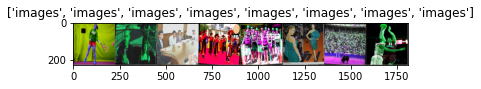

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
from facenet_pytorch import InceptionResnetV1 
# Define device and check if Nvidia GPU is available to use.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))


model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

list(model_ft.children())[-6:]

layer_list = list(model_ft.children())[-5:] # all final layers

model_ft = nn.Sequential(*list(model_ft.children())[:-5])

for param in model_ft.parameters():
    param.requires_grad = False
    
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
      
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x    
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)

model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)

model_ft.logits = nn.Linear(layer_list[2].out_features, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)

# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft

Running on device: cpu


Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

Model Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

In [ ]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.save(model, "/model.pt")

Epoch 0/0
----------


KeyboardInterrupt: ignored